# PEARL reimplementation

This code is adapted from:
https://github.com/Graph-COM/SPE
https://github.com/ehejin/Pearl-PE
```
@misc{kanatsoulis2025learningefficientpositionalencodings,
      title={Learning Efficient Positional Encodings with Graph Neural Networks}, 
      author={Charilaos I. Kanatsoulis and Evelyn Choi and Stephanie Jegelka and Jure Leskovec and Alejandro Ribeiro},
      year={2025},
      eprint={2502.01122},
      archivePrefix={arXiv},
      primaryClass={cs.LG},
      url={https://arxiv.org/abs/2502.01122}, 
}
```

In [1]:
!pip3 install torch_geometric

  Using cached torch_geometric-2.7.0-py3-none-any.whl.metadata (63 kB)
  Using cached fsspec-2026.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached psutil-7.2.1-cp36-abi3-macosx_11_0_arm64.whl.metadata (22 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.6.3-py3-none-any.whl.metadata (6.9 kB)
  Using cached certifi-2026.1.4-py3-none-any.whl.metadata (2.5 kB)
Using cached torch_geometric-2.7.0-py3-none-any.whl (1.3 MB)
Using cached psutil-7.2.1-cp36-abi3-macosx_11_0_arm64.whl (128 kB)
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
Using cached aio

In [2]:
from typing import List, Dict, Any
import random, numpy as np
from tqdm import tqdm
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch_geometric.nn import MessagePassing, global_mean_pool, global_add_pool
from torch_geometric.data import Data, Batch, DataLoader
from torch_geometric.utils import get_laplacian, to_dense_adj
from torch_geometric.datasets import ZINC
import matplotlib.pyplot as plt

## Hyperparameters

These are taken or derived directly from the paper's [source code](https://github.com/ehejin/Pearl-PE), for [ZINC](https://github.com/ehejin/Pearl-PE/blob/main/PEARL/zinc/runner.py).

In [3]:
class HyperParam:
    # Dataset properties (ZINC-specific)
    n_node_types: int = 28  # Number of atom types in ZINC
    n_edge_types: int = 3   # Number of bond types in ZINC

    # General hyperparameters
    seed: int = 42
    device: torch.device
    device_name: str

    # Model > MLP hyperparameters
    n_mlp_layers: int = 3
    mlp_hidden_dims: int = 128
    mlp_dropout_prob: float = 0.0
    mlp_norm_type: str = "batch"

    # Model > GINE hyperparameters
    n_base_layers: int = 4
    node_emb_dims: int = 128
    base_hidden_dims: int = 128
    gine_model_bn: bool = False
    pooling: str = "add"
    target_dim: int = 1

    # Model > GIN / SampleAggregator hyperparameters
    gin_sample_aggregator_bn: bool = True
    n_sample_aggr_layers: int = 8
    sample_aggr_hidden_dims: int = 40

    # Model > Positional Encoding / PEARL
    pe_dims: int = 37  # Based on SPE paper (Huang et al., 2023)
    basis: bool = True  # False for R-PEARL, True for B-PEARL
    num_samples: int = 120  # Number of samples for R-PEARL
    pearl_k: int = 7  # Polynomial filter order
    pearl_mlp_nlayers: int = 1
    pearl_mlp_hid: int = 37
    pearl_mlp_out: int = 37

    # Dataset hyperparameters
    use_subset: bool = True  # Use ZINC subset (12K graphs) or full (250K)
    train_batch_size: int = 32
    val_batch_size: int = 32
    test_batch_size: int = 32
    
    # Training hyperparameters
    learning_rate: float = 1e-3
    weight_decay: float = 1e-6
    num_epochs: int = 10  # Set to 1400 for full training (as in paper)
    n_warmup_steps: int = 100
    
    def __init__(self):
        if torch.backends.mps.is_available():
            self.device = torch.device("mps")
            self.device_name = "MPS"
        elif torch.cuda.is_available():
            self.device = torch.device("cuda")
            self.device_name = torch.cuda.get_device_name(0)
        else:
            self.device = torch.device("cpu")
            self.device_name = "CPU"
        self.set_seed()

    def set_seed(self) -> None:
        """Set random seeds for reproducibility."""
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)

    def device(self) -> torch.device:
        return self.device    

# Initialize hyperparameters
hp = HyperParam()
print(f"Device: {hp.device}")
print(f"Device name: {hp.device_name}")
print(f"Using {'ZINC subset (12K)' if hp.use_subset else 'Full ZINC (250K)'}")
print(f"Mode: {'R-PEARL' if not hp.basis else 'B-PEARL'}")

Device: mps
Device name: MPS
Using ZINC subset (12K)
Mode: B-PEARL


## General MLP

We apply this MLP on top of different models:
* `GINLayer`
* `RandomSampleAggregator` and `BasisSampleAggregator` (used by the `PEARLPositionalEncoder`)
* `GINEBaseModel` and `GINELayer`

Masking is supported. In that case, the mask shape must be compatible with the shape of the variable `X` forwarded to the model.

* for each layer:
  1. Linear layer (projection)
  2. Apply masking (if present)
  3. Normalization (batch or layer)
  4. Activation function (usually ReLU)
  5. Dropout (if configured)

* at the end:
  1. Final linear layer (projection)
  2. Dropout (if configured)

In [4]:
class MLPLayer(nn.Module):
    def __init__(self, in_dims: int, out_dims: int, hp: HyperParam):
        super(MLPLayer, self).__init__()
        self.linear = nn.Linear(in_dims, out_dims)
        self.normalization = nn.BatchNorm1d(out_dims) if hp.mlp_norm_type == "batch" else nn.LayerNorm(out_dims)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=hp.mlp_dropout_prob)

    def forward(self, X: torch.Tensor, mask=None) -> torch.Tensor:
        X = self.linear(X)
        if mask is not None:
            X[~mask] = 0

        if mask is None:
            shape = X.size()
            X = X.reshape(-1, shape[-1])
            X = self.normalization(X)
            X = X.reshape(shape)
        else:
            X[mask] = self.normalization(X[mask])

        X = self.activation(X)
        X = self.dropout(X)
        return X


class MLP(nn.Module):
    def __init__(self, in_dims: int, out_dims: int, hp: HyperParam):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(hp.n_mlp_layers - 1):
            self.layers.append(MLPLayer(in_dims, hp.mlp_hidden_dims, hp))
            in_dims = hp.mlp_hidden_dims
        self.linear = nn.Linear(hp.mlp_hidden_dims, out_dims)
        self.dropout = nn.Dropout(p=hp.mlp_dropout_prob)

    def forward(self, X: torch.Tensor, mask=None) -> torch.Tensor:
        for layer in self.layers:
            X = layer(X, mask=mask)
        X = self.linear(X)
        X = self.dropout(X)
        return X

    @property
    def out_dims(self) -> int:
        return self.linear.out_features

## GIN (Graph Isomorphism Network)

This is used as the final layer of the sample aggregator model that produces the positional embeddings.
We do not have edge embeddings as input, so a GIN is sufficient and we do not need a GINE in this case.

**NOTE** `node_dim=0` is crucial in our configuration, since the expected input `X` has dimensions:

0. Node dimension
1. Intermediate dimension: used to process M (or N) independent node attributes in parallel
2. Node attributes

After message passing (GIN layer), batch normalization is applied.
In the ZINC setting the paper code does not use residual connections; I follow the paper for consistency.
The paper also uses batch normalization (not layer normalization) for ZINC, so I keep the same choice here.

Masking is used by the B-PEARL implementation, not by R-PEARL.
We support both modes.

In [5]:
class GINLayer(MessagePassing):
    def __init__(self, in_dims: int, out_dims: int, hp: HyperParam):
        super(GINLayer, self).__init__(aggr="add", node_dim=0)
        self.eps = nn.Parameter(data=torch.randn(1))
        self.mlp = MLP(in_dims, out_dims, hp)

    def forward(self, X: torch.Tensor, edge_index: torch.Tensor, mask=None) -> torch.Tensor:
        S = self.propagate(edge_index, X=X)
        Z = (1 + self.eps) * X + S
        return self.mlp(Z, mask=mask)
    
    def message(self, X_j: torch.Tensor) -> torch.Tensor:
        return X_j

    @property
    def out_dims(self) -> int:
        return self.mlp.out_dims


class GIN(nn.Module):
    def __init__(self, hp: HyperParam, residual: bool = False):
        super(GIN, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList() if hp.gin_sample_aggregator_bn else None
        self.residual = residual
        
        in_dims = hp.pearl_mlp_out
        for _ in range(hp.n_sample_aggr_layers - 1):
            self.layers.append(GINLayer(in_dims, hp.sample_aggr_hidden_dims, hp))
            in_dims = hp.sample_aggr_hidden_dims
            if self.batch_norms is not None:
                self.batch_norms.append(nn.BatchNorm1d(hp.sample_aggr_hidden_dims))

        self.layers.append(GINLayer(hp.sample_aggr_hidden_dims, hp.pe_dims, hp))

    def forward(self, X: torch.Tensor, edge_index: torch.Tensor, mask=None) -> torch.Tensor:
        for i, layer in enumerate(self.layers):
            X0 = X
            X = layer(X, edge_index, mask=mask)
            if mask is not None:
                X[~mask] = 0
            if self.batch_norms is not None and i < len(self.layers) - 1:
                if mask is None:
                    X = self.batch_norms[i](X.transpose(2, 1)).transpose(2, 1) if X.ndim == 3 else self.batch_norms[i](X)
                else:
                    X[mask] = self.batch_norms[i](X[mask])
            if self.residual:
                X = X + X0
        return X

    @property
    def out_dims(self) -> int:
        return self.layers[-1].out_dims


## Positional Encoding (PEARL)

### Graph Shift Operator

As the GSO we use the symmetric normalized Laplacian: L = I - D^-1/2 A D^-1/2.

We compute a Laplacian instance for each `Data` item.
Laplacians from different items generally have different shapes because each graph can have a different number of nodes, so they cannot be batched in their final (dense) form.
The paper code base solves this by overriding the `Dataset` classes to handle collation of different-shaped Laplacians in the same batch.
I take a slightly different approach and split the normalized Laplacian generation into two methods.
The first method, `add_laplacian_transform`, computes the sparse Laplacian for each graph.
The second method, `get_per_graph_dense_laplacians`, takes the aggregated sparse Laplacians from a `Batch` and returns dense Laplacians, one per `Data` item.
The former is intended to be passed as the `transform` parameter to the `ZINC` dataset constructor; the latter is used during training to extract the list of Laplacians for a given `Batch` instance.

In [6]:
def add_laplacian_transform(data: Data) -> Data:
    """Pre-compute sparse Laplacian for each graph."""
    n = data.num_nodes
    L_edge_index, L_values = get_laplacian(data.edge_index, normalization="sym", num_nodes=n)
    data.lap_edge_index = L_edge_index
    data.lap_edge_attr = L_values
    return data


def get_per_graph_dense_laplacians(batch: Batch) -> List[torch.Tensor]:
    """Extract per-graph dense Laplacians from batched graph."""
    num_graphs = batch.num_graphs
    ptr = batch.ptr
    lap_edge_slices = batch._slice_dict['lap_edge_index']
    lap_attr_slices = batch._slice_dict['lap_edge_attr']
    
    laplacians = []
    for i in range(num_graphs):
        n_nodes = ptr[i + 1] - ptr[i]
        node_offset = ptr[i].item()
        edge_start = lap_edge_slices[i].item()
        edge_end = lap_edge_slices[i + 1].item()
        graph_lap_edge_index = batch.lap_edge_index[:, edge_start:edge_end] - node_offset
        attr_start = lap_attr_slices[i].item()
        attr_end = lap_attr_slices[i + 1].item()
        graph_lap_edge_attr = batch.lap_edge_attr[attr_start:attr_end]
        dense_lap = to_dense_adj(
            graph_lap_edge_index, 
            edge_attr=graph_lap_edge_attr, 
            max_num_nodes=n_nodes
        ).squeeze(0)
        laplacians.append(dense_lap)
    return laplacians

### Initial node attributes

In this method we generate the initial node attribute values for both R-PEARL and B-PEARL,
returning the list of M (or N) independent initial node attributes {q(m)}, m ∈ [1, M], q(m) ∈ R^N.

In [7]:
def initial_pe(batch: Batch, basis: bool, num_samples: int) -> List[torch.Tensor]:
    """Initialize PE basis (identity for B-PEARL, random for R-PEARL)."""
    ptr = batch.ptr
    num_graphs = batch.num_graphs
    device = batch.x.device
    W_list = []
    for i in range(num_graphs):
        n_nodes = (ptr[i + 1] - ptr[i]).item()
        W = torch.eye(n_nodes, device=device) if basis else torch.randn(n_nodes, num_samples, device=device)
        W_list.append(W)
    return W_list

### K-polynomial filter

Compute the items `[W, SW, S²W, ..., S^(k-1)W]` that will be used by the **combine** function to produce the positional embeddings at each message passing layer. For k=2, we recover the usual `[W, SW]`; here we allow k > 2.
Note: The filter (allowing k > 2) is applied only once. After that, each GINLayer implicitly applies a k=2 polynomial structure (combining self and 1-hop neighbor features), though using adjacency-based aggregation rather than the Laplacian.

In [8]:
def filter(S, W, k):
    """Apply polynomial filter: [W, SW, S²W, ..., S^(k-1)W]"""
    out = W
    w_list = [out.unsqueeze(-1)]
    for _ in range(k - 1):
        out = S @ out
        w_list.append(out.unsqueeze(-1))
    return torch.cat(w_list, dim=-1)

### Positional Encoder Model

The main encoder model, `PEARLPositionalEncoder`, starts from the per-graph Laplacians in a batch, the edge indices, and the initial node attributes, and produces the final positional embeddings for nodes.
For each data item (i.e., a single graph), the K-polynomial filter is applied to each Laplacian and each initial node attribute matrix.

The output shape of the filter is `[N x M x K]`, with M = N in the B-PEARL case. A linear projection layer expands each sample from dimension K (7 in our case) to the PEARL MLP hidden dimension (37 in our case). This projection is followed by batch normalization and an activation layer (ReLU in our case). Then the sample-aggregator models are applied.

The `RandomSampleAggregator` (used in R-PEARL) is simpler than the `BasisSampleAggregator` (used in B-PEARL) because in the first case the second dimension M (the number of samples) is fixed for all graphs, while in the latter the second dimension is N and can vary per graph. For the basis case we therefore pad to the maximum batch size `n_max` and use masking to compute exactly N independent processes for each node.
In both cases, values are summed over the second dimension (which disappears), and the final output of the encoding is `[N_sum, D_pe]`, where `N_sum` is the total number of nodes in the batch and `D_pe` is the positional encoding dimension applied to each node.

In [9]:
class RandomSampleAggregator(nn.Module):
    """R-PEARL: Aggregate random samples with averaging."""
    def __init__(self, hp: HyperParam):
        super(RandomSampleAggregator, self).__init__()
        self.gin = GIN(hp)
        self.mlp = MLP(hp.pe_dims, hp.pe_dims, hp)
        self.running_sum = 0

    def forward(self, W_list: List[torch.Tensor], edge_index: torch.Tensor, final=True) -> torch.Tensor:
        W = torch.cat(W_list, dim=0)
        PE = self.gin(W, edge_index)
        PE = PE.sum(dim=1)
        self.running_sum += PE
        if final:
            PE = self.running_sum
            self.running_sum = 0
        return PE

    @property
    def out_dims(self) -> int:
        return self.gin.out_dims


class BasisSampleAggregator(nn.Module):
    """B-PEARL: Aggregate basis vectors with summation pooling."""
    def __init__(self, hp: HyperParam):
        super(BasisSampleAggregator, self).__init__()
        self.gin = GIN(hp)
        self.mlp = MLP(hp.pe_dims, hp.pe_dims, hp)

    def forward(self, W_list: List[torch.Tensor], edge_index: torch.Tensor) -> torch.Tensor:
        n_max = max(W.size(0) for W in W_list)
        W_pad_list, mask = [], []
        for W in W_list:
            zeros = torch.zeros(W.size(0), n_max - W.size(1), W.size(2), device=W.device)
            W_pad_list.append(torch.cat([W, zeros], dim=1))
            mask.append((torch.arange(n_max, device=W.device) < W.size(0)).tile((W.size(0), 1)))
        W = torch.cat(W_pad_list, dim=0)
        mask = torch.cat(mask, dim=0)
        PE = self.gin(W, edge_index, mask=mask)
        return (PE * mask.unsqueeze(-1)).sum(dim=1)

    @property
    def out_dims(self) -> int:
        return self.gin.out_dims


class PEARLPositionalEncoder(nn.Module):
    """PEARL Positional Encoder with polynomial filtering."""
    def __init__(self, hp: HyperParam):
        super(PEARLPositionalEncoder, self).__init__()
        self.sample_aggr = BasisSampleAggregator(hp) if hp.basis else RandomSampleAggregator(hp)
        self.layers = nn.ModuleList([
            nn.Linear(
                hp.pearl_k if i == 0 else hp.pearl_mlp_hid,
                hp.pearl_mlp_hid if i < hp.pearl_mlp_nlayers - 1 else hp.pearl_mlp_out
            ) for i in range(hp.pearl_mlp_nlayers)
        ])
        self.norms = nn.ModuleList([
            nn.BatchNorm1d(hp.pearl_mlp_hid if i < hp.pearl_mlp_nlayers - 1 else hp.pearl_mlp_out)
            for i in range(hp.pearl_mlp_nlayers)
        ])
        self.activation = nn.ReLU()
        self.k = hp.pearl_k
        self.basis = hp.basis
        self.num_samples = hp.num_samples

    def forward(self, batch: Batch) -> torch.Tensor:
        Lap_list = get_per_graph_dense_laplacians(batch)
        edge_index = batch.edge_index
        W_init = initial_pe(batch, self.basis, self.num_samples)

        W_list = []
        for lap, w in zip(Lap_list, W_init):
            output = filter(lap, w, self.k)
            if len(self.layers) > 0:
                for layer, bn in zip(self.layers, self.norms):
                    output = output.transpose(0, 1)
                    output = layer(output)
                    output = bn(output.transpose(1, 2)).transpose(1, 2)
                    output = self.activation(output)
                    output = output.transpose(0, 1)
            W_list.append(output)
        return self.sample_aggr(W_list, edge_index)

    @property
    def out_dims(self) -> int:
        return self.sample_aggr.out_dims

## GINE (Graph Isomorphism Network with Edge Features)

Similar to the GIN we introduced before, with some differences:

1. This is used not to compute the positional encoding for each node, but to compute the final regression output. This means that a global pooling operation is required; we use `sum` in this experiment.
2. We need to include signals from the edges.
3. We do not need to handle different sub-dimension sizes with masking.
4. The `GINELayer` (see `message`) applies a ReLU activation function to the sum of the node and edge features.
5. Batch normalization is disabled in this experiment.
6. Residual connections are applied after each layer (4).
7. Each `GINELayer` has an embedding layer that converts each edge type into an embedding compatible with the input dimension of the MLP in the same `GINELayer`.

In [10]:
class GINELayer(MessagePassing):
    def __init__(self, in_dims: int, out_dims: int, hp: HyperParam):
        super(GINELayer, self).__init__(aggr="add", node_dim=0)
        self.edge_features = nn.Embedding(hp.n_edge_types + 1, in_dims)
        self.pe_embedding = MLP(hp.pe_dims, in_dims, hp)
        self.eps = nn.Parameter(data=torch.randn(1))
        self.mlp = MLP(in_dims, out_dims, hp)

    def forward(self, X_n: torch.Tensor, edge_index: torch.Tensor,
                edge_attr: torch.Tensor, PE: torch.Tensor) -> torch.Tensor:
        X_e = self.edge_features(edge_attr)
        X_n = X_n + self.pe_embedding(PE)
        S = self.propagate(edge_index, X=X_n, X_e=X_e)
        Z = (1 + self.eps) * X_n + S
        return self.mlp(Z)

    def message(self, X_j: torch.Tensor, X_e: torch.Tensor) -> torch.Tensor:
        return F.relu(X_j + X_e)


class GINE(nn.Module):
    def __init__(self, hp: HyperParam):
        super(GINE, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList() if hp.gine_model_bn else None

        in_dims = hp.node_emb_dims
        for _ in range(hp.n_base_layers - 1):
            self.layers.append(GINELayer(in_dims, hp.base_hidden_dims, hp))
            in_dims = hp.base_hidden_dims
            if self.batch_norms is not None:
                self.batch_norms.append(nn.BatchNorm1d(hp.base_hidden_dims))

        self.layers.append(GINELayer(hp.base_hidden_dims, hp.base_hidden_dims, hp))

    def forward(self, X_n: torch.Tensor, edge_index: torch.Tensor,
                edge_attr: torch.Tensor, PE: torch.Tensor) -> torch.Tensor:
        for i, layer in enumerate(self.layers):
            X_0 = X_n
            X_n = layer(X_n, edge_index, edge_attr, PE)
            if self.batch_norms is not None and i < len(self.layers) - 1:
                X_n = self.batch_norms[i](X_n)
            X_n = X_n + X_0  # Residual connection
        return X_n


class GINEBaseModel(nn.Module):
    def __init__(self, hp: HyperParam):
        super(GINEBaseModel, self).__init__()
        self.gine = GINE(hp)
        self.mlp = MLP(hp.base_hidden_dims, hp.target_dim, hp)
        self.pooling = global_mean_pool if hp.pooling == 'mean' else global_add_pool

    def forward(self, X_n: torch.Tensor, edge_index: torch.Tensor,
                edge_attr: torch.Tensor, PE: torch.Tensor, batch: torch.Tensor) -> torch.Tensor:
        X_n = self.gine(X_n, edge_index, edge_attr, PE)
        X_n = self.pooling(X_n, batch)
        Y_pred = self.mlp(X_n)
        return Y_pred.squeeze(dim=1)

## PEARL GNN (Root) Model

Finally, here we have the root model. Node features are produced as trainable embeddings. At the end of training we have a lookup table that maps each of the 28 ZINC node types to an embedding of size 128 (in this experiment).
The positional embeddings are linearly projected from the positional encoding dimension (37 in our case) to the structural embedding dimension (128) and then summed with the node embeddings.
The GINE we presented before is used to generate the final output, which is a single scalar for ZINC (a regression task).

In [11]:
class PEARL_GNN_Model(nn.Module):
    def __init__(self, hp: HyperParam):
        super(PEARL_GNN_Model, self).__init__()
        self.node_features = nn.Embedding(hp.n_node_types, hp.node_emb_dims)
        self.positional_encoding = PEARLPositionalEncoder(hp)
        self.pe_embedding = nn.Linear(self.positional_encoding.out_dims, hp.node_emb_dims)
        self.base_model = GINEBaseModel(hp)

    def forward(self, batch: Batch) -> torch.Tensor:
        X_n = self.node_features(batch.x.squeeze(dim=1))
        PE = self.positional_encoding(batch)
        X_n = X_n + self.pe_embedding(PE)
        return self.base_model(X_n, batch.edge_index, batch.edge_attr, PE, batch.batch)

    def get_param_groups(self) -> List[Dict[str, Any]]:
        return [{"name": name, "params": [param]} for name, param in self.named_parameters()]


# Initialize model
model = PEARL_GNN_Model(hp)
model.to(hp.device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 644,241
Trainable parameters: 644,241


## Data Loading

Load the ZINC dataset with Laplacian transforms.

In [12]:
# Load ZINC dataset
root = "./data/ZINC"

print("Loading datasets...")
train_dataset = ZINC(root=root, subset=hp.use_subset, split="train", transform=add_laplacian_transform)
val_dataset = ZINC(root=root, subset=hp.use_subset, split="val", transform=add_laplacian_transform)
test_dataset = ZINC(root=root, subset=hp.use_subset, split="test", transform=add_laplacian_transform)

train_loader = DataLoader(train_dataset, batch_size=hp.train_batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=hp.val_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=hp.test_batch_size, shuffle=False, num_workers=0)

print(f"\nDataset statistics:")
print(f"Train: {len(train_dataset)} graphs")
print(f"Val: {len(val_dataset)} graphs")
print(f"Test: {len(test_dataset)} graphs")
print(f"\nBatch statistics:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Loading datasets...

Dataset statistics:
Train: 10000 graphs
Val: 1000 graphs
Test: 1000 graphs

Batch statistics:
Train batches: 313
Val batches: 32
Test batches: 32


/var/folders/zs/g2xjsny16274r261g5z67yqh0000gn/T/ipykernel_41211/1117007997.py:9: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_dataset, batch_size=hp.train_batch_size, shuffle=True, num_workers=0)
/var/folders/zs/g2xjsny16274r261g5z67yqh0000gn/T/ipykernel_41211/1117007997.py:10: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(val_dataset, batch_size=hp.val_batch_size, shuffle=False, num_workers=0)
/var/folders/zs/g2xjsny16274r261g5z67yqh0000gn/T/ipykernel_41211/1117007997.py:11: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_dataset, batch_size=hp.test_batch_size, shuffle=False, num_workers=0)


## Training Setup

Setup optimizer, scheduler, and loss functions.

In [13]:
# Optimizer
optimizer = torch.optim.Adam(
    model.get_param_groups(),
    lr=hp.learning_rate,
    weight_decay=hp.weight_decay
)

# Learning rate scheduler with warmup
n_total_steps = len(train_loader) * hp.num_epochs

def lr_lambda(curr_step: int) -> float:
    """Linear warmup followed by linear decay."""
    if curr_step < hp.n_warmup_steps:
        return curr_step / max(1, hp.n_warmup_steps)
    else:
        return max(0.0, (n_total_steps - curr_step) / max(1, n_total_steps - hp.n_warmup_steps))

scheduler = LambdaLR(optimizer, lr_lambda)

# Loss functions
criterion = nn.L1Loss(reduction="mean")  # MAE for training
metric = nn.L1Loss(reduction="sum")  # MAE for evaluation

print(f"Total training steps: {n_total_steps:,}")
print(f"Warmup steps: {hp.n_warmup_steps}")
print(f"Initial learning rate: {hp.learning_rate}")

Total training steps: 3,130
Warmup steps: 100
Initial learning rate: 0.001


## Training Functions

In [14]:
def train_epoch(model, loader, optimizer, scheduler, criterion, device, epoch, num_epochs):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for batch in pbar:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        output = model(batch)
        loss = criterion(output, batch.y)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # @fax4ever:
        # Instead of using `mean` as the reduction and then multiplying by the batch size,
        # we could have used `sum` for the metric directly.
        # I kept the paper's approach here for consistency.
        total_loss += loss.item() * batch.y.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    return total_loss / len(loader.dataset)


def evaluate_epoch(model, loader, metric, device, desc="Eval"):
    """Evaluate on validation or test set."""
    model.eval()
    total_loss = 0.0
    
    pbar = tqdm(loader, desc=f"         [{desc}]", leave=False)
    with torch.no_grad():
        for batch in pbar:
            batch = batch.to(device)
            output = model(batch)
            loss = metric(output, batch.y)
            total_loss += loss.item()
    
    return total_loss / len(loader.dataset)


def plot_training_progress(train_losses, val_losses, test_losses):
    """Plot training progress."""
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Training MAE')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_losses, 'g-', label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Validation MAE')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs, test_losses, 'r-', label='Test MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Test MAE')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Training Loop

In [15]:
# Training history
train_losses = []
val_losses = []
test_losses = []
best_val_loss = 999.0

print(f"\nStarting training for {hp.num_epochs} epochs...")
print("=" * 80)

for epoch in range(hp.num_epochs):
    # Train
    train_loss = train_epoch(
        model, train_loader, optimizer, scheduler, criterion, hp.device, epoch, hp.num_epochs
    )
    
    # Evaluate
    val_loss = evaluate_epoch(model, val_loader, metric, hp.device, desc="Val")
    test_loss = evaluate_epoch(model, test_loader, metric, hp.device, desc="Test")
    
    # Record
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    # Print progress
    print(f"Epoch {epoch+1}/{hp.num_epochs} | "
          f"Train MAE: {train_loss:.4f} | "
          f"Val MAE: {val_loss:.4f} | "
          f"Test MAE: {test_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_pearl_model.pth')
        print(f"  → Best model updated! (Val MAE: {val_loss:.4f})")

print("\n" + "=" * 80)
print("Training completed!")
print(f"Best validation MAE: {best_val_loss:.4f}")


Starting training for 10 epochs...


Epoch 1/10 | Train MAE: 1.0067 | Val MAE: 0.5957 | Test MAE: 0.5968
  → Best model updated! (Val MAE: 0.5957)


Epoch 2/10 | Train MAE: 0.5634 | Val MAE: 0.5582 | Test MAE: 0.5348
  → Best model updated! (Val MAE: 0.5582)


Epoch 3/10 | Train MAE: 0.4837 | Val MAE: 0.3602 | Test MAE: 0.3508
  → Best model updated! (Val MAE: 0.3602)


Epoch 4/10 | Train MAE: 0.4373 | Val MAE: 0.3600 | Test MAE: 0.3469
  → Best model updated! (Val MAE: 0.3600)


Epoch 5/10 | Train MAE: 0.4187 | Val MAE: 0.3510 | Test MAE: 0.3347
  → Best model updated! (Val MAE: 0.3510)


Epoch 6/10 | Train MAE: 0.3874 | Val MAE: 0.2840 | Test MAE: 0.2602
  → Best model updated! (Val MAE: 0.2840)


Epoch 7/10 | Train MAE: 0.3814 | Val MAE: 0.3697 | Test MAE: 0.3383


Epoch 8/10 | Train MAE: 0.3498 | Val MAE: 0.2469 | Test MAE: 0.2193
  → Best model updated! (Val MAE: 0.2469)


Epoch 9/10 | Train MAE: 0.3338 | Val MAE: 0.2171 | Test MAE: 0.1821
  → Best model updated! (Val MAE: 0.2171)


Epoch 10/10 | Train MAE: 0.3196 | Val MAE: 0.1959 | Test MAE: 0.1606
  → Best model updated! (Val MAE: 0.1959)

Training completed!
Best validation MAE: 0.1959


## Results Visualization

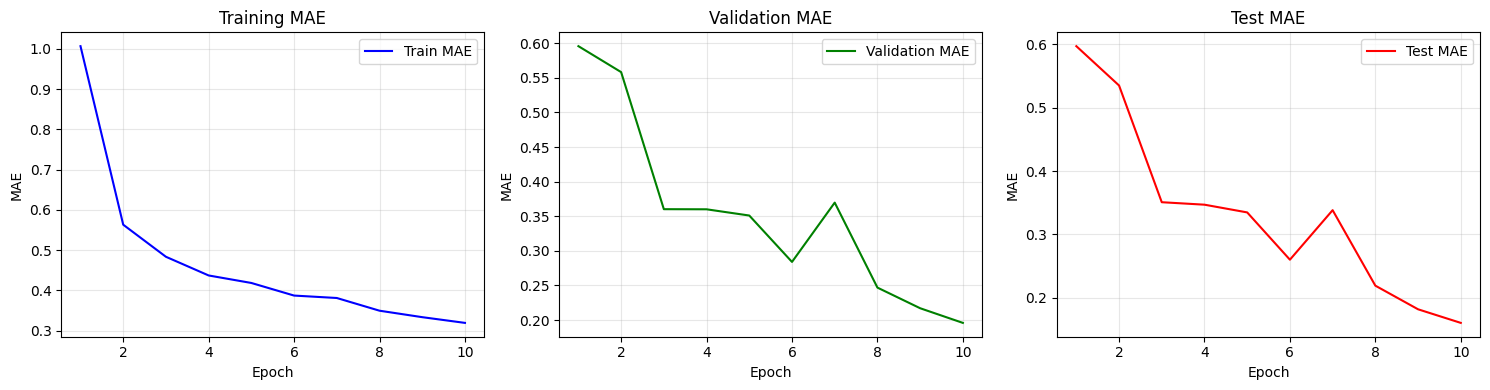


Final Results:
Best Validation MAE: 0.1959
Final Train MAE: 0.3196
Final Test MAE: 0.1606



Test MAE with best model: 0.1606


In [16]:
# Plot training progress
plot_training_progress(train_losses, val_losses, test_losses)

# Print final results
print("\nFinal Results:")
print(f"Best Validation MAE: {best_val_loss:.4f}")
print(f"Final Train MAE: {train_losses[-1]:.4f}")
print(f"Final Test MAE: {test_losses[-1]:.4f}")

# Load best model and evaluate
model.load_state_dict(torch.load('best_pearl_model.pth'))
final_test_loss = evaluate_epoch(model, test_loader, metric, hp.device, desc="Final Test")
print(f"\nTest MAE with best model: {final_test_loss:.4f}")